# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170498071/170498071 [00:01<00:00, 94405677.48it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


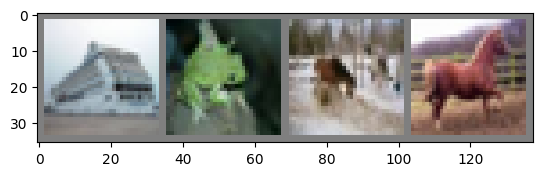

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
class BasicBlockNet(nn.Module):
    def __init__(self, n_classes=10):
        super(BasicBlockNet, self).__init__()

        self.sub_model0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
        )

        self.sub_model1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=1))

        self.model = nn.Sequential(nn.ReLU())

        self.avg_pool = nn.AvgPool2d(kernel_size=(8, 8))

        self.res_model = nn.Linear(32 * 4 * 4, n_classes)

    def forward(self, x):
        out1 = self.sub_model0(x)
        out2 = self.sub_model1(x)

        out = self.model(out1 + out2)
        out = self.avg_pool(out)
        out = out.view(x.size(0), -1)
        out = self.res_model(out)

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (sub_model0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (sub_model1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (model): Sequential(
    (0): ReLU()
  )
  (avg_pool): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0)
  (res_model): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
criterion = nn.CrossEntropyLoss()

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:

        # Move data and target tensors to the GPU
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        loss_log.append(loss.item())

        # Calculate the accuracy
        predicted_labels = torch.max(output, 1)[1]
        accuracy = (predicted_labels == target).sum().item() / target.shape[0]
        acc_log.append(accuracy)

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:

        # Move data and target tensors to the GPU
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        loss.backward()

        # Update the model parameters
        optimizer.step()
        optimizer.zero_grad()

        # Log the loss
        loss_log.append(loss.item())

        # Calculate the accuracy
        predicted_labels = torch.max(output, 1)[1]
        accuracy = (predicted_labels == target).sum().item() / target.shape[0]
        acc_log.append(accuracy)

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4574005554755383, train acc: 0.48334666361974404
 val loss: 1.2326545677286513, val acc: 0.557845744680851

Epoch 1
 train loss: 1.142717773343353, train acc: 0.6026744907286498
 val loss: 1.1232300834452853, val acc: 0.6112145390070923

Epoch 2
 train loss: 1.0369869488030945, train acc: 0.6418288064768869
 val loss: 1.0700686155481542, val acc: 0.6301418439716311

Epoch 3
 train loss: 0.9820962611456457, train acc: 0.6587881953512668
 val loss: 1.0303017758308572, val acc: 0.6421099290780141

Epoch 4
 train loss: 0.9484432129363037, train acc: 0.6700794920344737
 val loss: 0.9992855328194639, val acc: 0.6518173758865248

Epoch 5
 train loss: 0.9247601751435609, train acc: 0.6786652846696265
 val loss: 0.9600881520737993, val acc: 0.6702127659574468

Epoch 6
 train loss: 0.8977842182738254, train acc: 0.6868022003133977
 val loss: 1.0252701363664993, val acc: 0.6511968085106383

Epoch 7
 train loss: 0.8794297071435988, train acc: 0.6944004635675111
 val loss: 0.

Посчитайте точность на тестовой выборке:

In [12]:
_, accuracy = test(net, test_loader)
print(accuracy)

0.6896894904458599


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

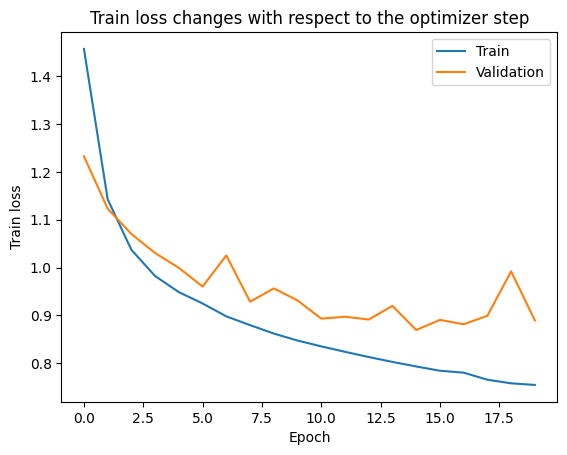

In [13]:
llm = np.array(train_loss_log).reshape(20, -1)

plt.plot((np.mean(llm, axis=1)), label='Train')
plt.plot(val_loss_log, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Train loss')
plt.title('Train loss changes with respect to the optimizer step')
plt.legend()

plt.show()

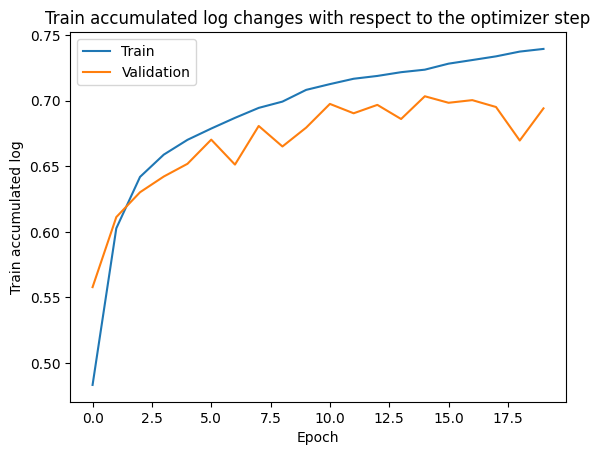

In [14]:

alm = np.array(train_acc_log).reshape(20, -1)

plt.plot((np.mean(alm, axis=1)), label='Train')
plt.plot(val_acc_log, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Train accumulated log')
plt.title('Train accumulated log changes with respect to the optimizer step')
plt.legend()

plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [15]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4661093514405832, train acc: 0.47676041394620006
 val loss: 1.2842961876950365, val acc: 0.5435948581560284

Epoch 1
 train loss: 1.1472592087942677, train acc: 0.5989080047009663
 val loss: 1.1023797986355233, val acc: 0.6166223404255319

Epoch 2
 train loss: 1.0461438928051447, train acc: 0.6363647492817969
 val loss: 1.168322369392882, val acc: 0.5956338652482269

Epoch 3
 train loss: 0.98508560603018, train acc: 0.6558092844084618
 val loss: 0.9771445385953214, val acc: 0.6654255319148936

Epoch 4
 train loss: 0.9423769530474159, train acc: 0.6712016845129277
 val loss: 1.00440399570668, val acc: 0.6533466312056737

Epoch 5
 train loss: 0.9085615046826315, train acc: 0.6844435557586838
 val loss: 0.9282751519629295, val acc: 0.680186170212766

Epoch 6
 train loss: 0.8902051158971281, train acc: 0.688503852180726
 val loss: 0.9569100560025966, val acc: 0.6700797872340426

Epoch 7
 train loss: 0.8732457372344609, train acc: 0.696632606424654
 val loss: 0.890650

Посчитайте точность на тестовой выборке:

In [16]:
_, accuracy = test(net, test_loader)
print(accuracy)

0.7139729299363057


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [17]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.8587567810602554, train acc: 0.3467778793418647
 val loss: 1.6385202691910115, val acc: 0.4318484042553192

Epoch 1
 train loss: 1.5725944432305679, train acc: 0.4474079394097676
 val loss: 1.4884773518176788, val acc: 0.47794769503546103

Epoch 2
 train loss: 1.4449481693874549, train acc: 0.4921242491512144
 val loss: 1.407864698450616, val acc: 0.5049645390070922

Epoch 3
 train loss: 1.3607818029916265, train acc: 0.5226029968660224
 val loss: 1.314230895549693, val acc: 0.5407358156028369

Epoch 4
 train loss: 1.2996278154566694, train acc: 0.5454549164272656
 val loss: 1.2576098254386414, val acc: 0.5643173758865248

Epoch 5
 train loss: 1.2457318078229371, train acc: 0.5637078871768085
 val loss: 1.2151580818155978, val acc: 0.5780363475177306

Epoch 6
 train loss: 1.2047246301195957, train acc: 0.5813569143379472
 val loss: 1.2030140369496447, val acc: 0.5804299645390072

Epoch 7
 train loss: 1.1603824382944123, train acc: 0.5959005288587098
 val loss: 1.

In [18]:
_, accuracy = test(net, test_loader)
print(accuracy)

0.6500796178343949


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

StepLR снижает скорость обучения с помощью мультипликативного коэффициента после каждого предопределенного количества шагов обучения.

In [19]:
from torch.optim.lr_scheduler import StepLR

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size = 4, gamma = 0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.8181264873396543, train acc: 0.36769146644032386
 val loss: 1.613689500727552, val acc: 0.4430629432624113

Epoch 1
 train loss: 1.527141192495496, train acc: 0.466905523635414
 val loss: 1.449241871529437, val acc: 0.49598847517730493

Epoch 2
 train loss: 1.4108114791744588, train acc: 0.5055171062940715
 val loss: 1.359241789452573, val acc: 0.5210771276595745

Epoch 3
 train loss: 1.337416520938141, train acc: 0.5311724667014887
 val loss: 1.2879293170381099, val acc: 0.5473625886524822

Epoch 4
 train loss: 1.2741687484153663, train acc: 0.5534653303734657
 val loss: 1.2873410628197042, val acc: 0.5449024822695034

Epoch 5
 train loss: 1.248206129784558, train acc: 0.5649280164533821
 val loss: 1.228061634175321, val acc: 0.5693705673758864

Epoch 6
 train loss: 1.226360689351502, train acc: 0.5745380647688692
 val loss: 1.2103273556587544, val acc: 0.5753324468085106

Epoch 7
 train loss: 1.2046713797440258, train acc: 0.5814018020370855
 val loss: 1.183899

In [20]:
_, accuracy = test(net, test_loader)
print(accuracy)

0.6167396496815286



ExponentialLR снижает скорость обучения на мультипликативный коэффициент на каждом этапе обучения.

In [21]:
from torch.optim.lr_scheduler import ExponentialLR

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma = 0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.7863161476700136, train acc: 0.3716660681640115
 val loss: 1.5631710524254656, val acc: 0.4544104609929078

Epoch 1
 train loss: 1.5144175262730126, train acc: 0.46956613998433006
 val loss: 1.460100990660647, val acc: 0.47721631205673765

Epoch 2
 train loss: 1.4478294454937226, train acc: 0.49119793026899977
 val loss: 1.4218035256609003, val acc: 0.49796099290780144

Epoch 3
 train loss: 1.4202538057480696, train acc: 0.5025830830504049
 val loss: 1.406225406869929, val acc: 0.505008865248227

Epoch 4
 train loss: 1.408335151140607, train acc: 0.5078186210498825
 val loss: 1.3971312086632912, val acc: 0.5080008865248228

Epoch 5
 train loss: 1.4017851289491112, train acc: 0.5100915709062418
 val loss: 1.3929438951167654, val acc: 0.5100620567375886

Epoch 6
 train loss: 1.3980016514413753, train acc: 0.5107485635936275
 val loss: 1.3909962613531883, val acc: 0.5103945035460993

Epoch 7
 train loss: 1.3956439111524788, train acc: 0.5113402650822669
 val loss: 1

In [22]:
_, accuracy = test(net, test_loader)
print(accuracy)

0.5144307324840764



PolynomialLR снижает скорость обучения, используя полиномиальную функцию для определенного количества шагов.

In [23]:
from torch.optim.lr_scheduler import PolynomialLR

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = PolynomialLR(optimizer, total_iters = 8, power = 1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.841511742942294, train acc: 0.3552738965787412
 val loss: 1.6187521594635983, val acc: 0.4410682624113475

Epoch 1
 train loss: 1.541307832248904, train acc: 0.46391437059284407
 val loss: 1.4580060811752968, val acc: 0.48687943262411343

Epoch 2
 train loss: 1.426908458390663, train acc: 0.5028972969443719
 val loss: 1.3892384995805456, val acc: 0.5145833333333334

Epoch 3
 train loss: 1.3602927855643319, train acc: 0.5251371115173674
 val loss: 1.3399447491828431, val acc: 0.5278812056737588

Epoch 4
 train loss: 1.3178170605594977, train acc: 0.5412721990075738
 val loss: 1.303973744777923, val acc: 0.5431959219858157

Epoch 5
 train loss: 1.2875989736543059, train acc: 0.5514127383128755
 val loss: 1.2699140315360211, val acc: 0.5552969858156029

Epoch 6
 train loss: 1.2652293060117927, train acc: 0.5608187516322799
 val loss: 1.2590711895455706, val acc: 0.5611480496453901

Epoch 7
 train loss: 1.247728973245708, train acc: 0.5658461739357534
 val loss: 1.24

In [24]:
_, accuracy = test(net, test_loader)
print(accuracy)

0.5687699044585988


OneCycleLR снижает скорость обучения в соответствии с политикой скорости обучения 1 цикл.

В отличие от многих других планировщиков скорости обучения, скорость обучения снижается не только в процессе обучения. Вместо этого скорость обучения увеличивается от начальной скорости обучения до некоторой максимальной скорости обучения, а затем снова уменьшается.

In [25]:
from torch.optim.lr_scheduler import OneCycleLR

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr = 1e-3, steps_per_epoch = 8, epochs = 4, anneal_strategy = 'cos')
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 2.209297256016426, train acc: 0.18546781143901803
 val loss: 2.0964925476845275, val acc: 0.2575576241134752

Epoch 1
 train loss: 2.016399740301059, train acc: 0.29360635936275786
 val loss: 1.9441151837085155, val acc: 0.3223847517730496

Epoch 2
 train loss: 1.8688303245268967, train acc: 0.35799980412640375
 val loss: 1.7846397815866673, val acc: 0.390802304964539

Epoch 3
 train loss: 1.717586116337471, train acc: 0.40764151867328285
 val loss: 1.6410516120017844, val acc: 0.43326684397163123

Epoch 4
 train loss: 1.5854224864482007, train acc: 0.44930546487333506
 val loss: 1.5203338430282918, val acc: 0.4654033687943262

Epoch 5
 train loss: 1.490577694484913, train acc: 0.47752758553147034
 val loss: 1.443274354427419, val acc: 0.4922429078014185

Epoch 6
 train loss: 1.424270943270305, train acc: 0.5001632279968661
 val loss: 1.3857713349322056, val acc: 0.5127216312056738

Epoch 7
 train loss: 1.3754984033609003, train acc: 0.5186039109428049
 val loss: 1

In [26]:
_, accuracy = test(net, test_loader)
print(accuracy)

0.6211186305732485


Your answers here:

* OneCycleLR: 0.62
* PolynomialLR: 0.56
* ExponentialLR: 0.51
* StepLR: 0.62

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

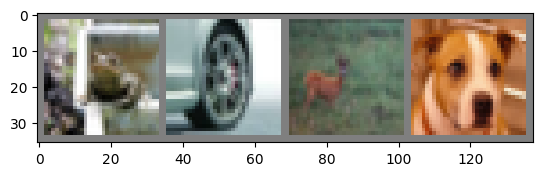

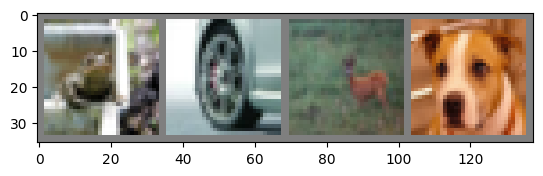

In [28]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [30]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma = 0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4858206414653352, train acc: 0.46958654348393836
 val loss: 1.3042994897416298, val acc: 0.5319592198581561

Epoch 1
 train loss: 1.1415691376822086, train acc: 0.6002260707756595
 val loss: 1.1340991357539563, val acc: 0.5976728723404255

Epoch 2
 train loss: 1.0120568302693271, train acc: 0.64737447767041
 val loss: 1.0445426826781414, val acc: 0.6373226950354609

Epoch 3
 train loss: 0.9459847333880186, train acc: 0.6722504243927918
 val loss: 0.9393145520636376, val acc: 0.6728501773049647

Epoch 4
 train loss: 0.9129711240257598, train acc: 0.6845129276573518
 val loss: 0.9159607547394772, val acc: 0.682424645390071

Epoch 5
 train loss: 0.8949797296218942, train acc: 0.6925437451031601
 val loss: 0.9013043690235056, val acc: 0.6885195035460993

Epoch 6
 train loss: 0.8817113745800974, train acc: 0.697918026899974
 val loss: 0.8983229010663134, val acc: 0.6891843971631205

Epoch 7
 t

Посчитайте точность на тестовой выборке:

In [31]:
_, accuracy = test(net, test_loader)
print(accuracy)

0.6853105095541401


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [38]:
transform = transforms.Compose(
        [transforms.RandomGrayscale(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma = 0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 0
 train loss: 1.5116538944802294, train acc: 0.46166998563593625
 val loss: 1.2824975105042153, val acc: 0.5411790780141844



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    AssertionError: self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
can only test a child process
    Exception ignored in: if w.is_aliv

Epoch 1
 train loss: 1.1622637782715792, train acc: 0.5939050665970228
 val loss: 1.1160917946632871, val acc: 0.6126773049645391



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 2
 train loss: 1.0291178950008135, train acc: 0.6446281666231392
 val loss: 1.076408662440929, val acc: 0.6302304964539008



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/pyt

Epoch 3
 train loss: 0.9647272096255579, train acc: 0.664986778532254
 val loss: 0.9729863377327614, val acc: 0.6653812056737588



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
AssertionError    : can only test a child process
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in:     if w.is_aliv

Epoch 4
 train loss: 0.9303505338959982, train acc: 0.6799507051449465
 val loss: 0.958786166728811, val acc: 0.6688829787234043



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a

Epoch 5
 train loss: 0.9127529263496399, train acc: 0.6857412183337687
 val loss: 0.9466402479942809, val acc: 0.6728280141843971



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 6
 train loss: 0.9023309661657762, train acc: 0.6900300339514234
 val loss: 0.9383507353194216, val acc: 0.6775930851063829



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 7
 train loss: 0.897513826760775, train acc: 0.6910910159310525
 val loss: 0.9356833650710735, val acc: 0.678235815602837



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 8
 train loss: 0.8946780000133968, train acc: 0.6925967942021416
 val loss: 0.9343728945610371, val acc: 0.6777703900709221



Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520><function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

Epoch 9
 train loss: 0.8934070063683407, train acc: 0.6928579589971272
 val loss: 0.9336545208667187, val acc: 0.6799645390070923



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 10
 train loss: 0.8893763307461573, train acc: 0.6945840950639853
 val loss: 0.93663444595134, val acc: 0.6770833333333333



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
AssertionError: can only test a child process

Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pyt

Epoch 11
 train loss: 0.8909520791261244, train acc: 0.6936700182815356
 val loss: 0.9348172251214373, val acc: 0.6763297872340426



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

AssertionError    : can only test a child processif w.is_alive():

Exception ignored

Epoch 12
 train loss: 0.8905477554314315, train acc: 0.6941882671715852
 val loss: 0.9353233722930259, val acc: 0.6765070921985816



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>

AssertionError: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
can only test a child process    
self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    <function _M

Epoch 13
 train loss: 0.8944202008805283, train acc: 0.6927151344998694
 val loss: 0.9336822618829443, val acc: 0.6781693262411348



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
:     self._shutdown_workers()
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
if w.is_alive():
Exception ignored

Epoch 14
 train loss: 0.8885168234870464, train acc: 0.694763645860538
 val loss: 0.9354049986981331, val acc: 0.678235815602837



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    AssertionError: can only test a child processself._shutdown_workers()

Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _Multi

Epoch 15
 train loss: 0.8919429092564138, train acc: 0.6936292112823191
 val loss: 0.9312746387846926, val acc: 0.6795656028368795



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>if w.is_alive():
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored 

Epoch 16
 train loss: 0.8904176834950281, train acc: 0.6945555301645339
 val loss: 0.9357502985507884, val acc: 0.676706560283688



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

AssertionError: can only test a child process    
if w.is_alive():
  File "/usr/lib/

Epoch 17
 train loss: 0.8912959621854848, train acc: 0.6955879472447114
 val loss: 0.9338310439535912, val acc: 0.6777925531914893



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
AssertionError: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/local/lib/python3.10/dist-packages/tor

Epoch 18
 train loss: 0.889099998818455, train acc: 0.6942862039697049
 val loss: 0.9332541513950267, val acc: 0.6799645390070923



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():
AssertionError: can only test a child process

  File "/usr/lib/

Epoch 19
 train loss: 0.8896440166224073, train acc: 0.6934210955863149
 val loss: 0.9323798689436406, val acc: 0.6796985815602837



In [39]:
_, accuracy = test(net, test_loader)
print(accuracy)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/pyt

0.6772492038216561


In [35]:
transform = transforms.Compose(
        [transforms.RandomVerticalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma = 0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6537530478873244, train acc: 0.3996392661269261
 val loss: 1.5146409684039177, val acc: 0.4485815602836879

Epoch 1
 train loss: 1.3568368180360393, train acc: 0.5181019848524419
 val loss: 1.3377701726365596, val acc: 0.5157136524822695

Epoch 2
 train loss: 1.2309257001284053, train acc: 0.5679558957952467
 val loss: 1.2201073915400404, val acc: 0.566622340425532

Epoch 3
 train loss: 1.1609411858553425, train acc: 0.5905792961608776
 val loss: 1.1458548736064993, val acc: 0.5984485815602838

Epoch 4
 train loss: 1.1256379529806553, train acc: 0.6052698158788196
 val loss: 1.1255705666034779, val acc: 0.6055186170212766

Epoch 5
 train loss: 1.1044959654755742, train acc: 0.6127415774353617
 val loss: 1.1101485856035922, val acc: 0.615514184397163

Epoch 6
 train loss: 1.0946074662086516, train acc: 0.6183811047270827
 val loss: 1.1091831998622164, val acc: 0.6101063829787234

Epoch 7
 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a

Epoch 19
 train loss: 1.084859868944018, train acc: 0.6228209062418386
 val loss: 1.1018008440098863, val acc: 0.6151595744680851



In [36]:
_, accuracy = test(net, test_loader)
print(accuracy)

0.6142515923566879


In [40]:
transform = transforms.Compose(
        [transforms.RandomInvert(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma = 0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()
AssertionError: can only test a child process

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in:     <function _M

Epoch 0
 train loss: 1.7323623193901243, train acc: 0.385883226691042
 val loss: 1.4910088331141371, val acc: 0.4790115248226951



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>: can only test a child process

Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/u

Epoch 1
 train loss: 1.3455679806756362, train acc: 0.5330455079655263
 val loss: 1.301407907617853, val acc: 0.544459219858156



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

Epoch 2
 train loss: 1.1917984663241523, train acc: 0.5879390833115695
 val loss: 1.224295248883836, val acc: 0.5796985815602838



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Traceback (most recent call last):
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/pyt

Epoch 3
 train loss: 1.1182928551703528, train acc: 0.6167855510577175
 val loss: 1.1074932306370837, val acc: 0.6199024822695035



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>    
if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():AssertionError: 
  File "/usr/lib/python3.10/multiprocessing/pro

Epoch 4
 train loss: 1.0838491336955014, train acc: 0.6280972512405328
 val loss: 1.093570093905672, val acc: 0.623825354609929



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

assert self._parent_pid == os.getpid(), 'can only test a child process'    self._shutdown_workers()AssertionError: 
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

Exception ignored in:     if w.is_aliv

Epoch 5
 train loss: 1.0641511534859973, train acc: 0.6346467746147819
 val loss: 1.0753218475808488, val acc: 0.632136524822695



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>    
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    self._shutdown_workers()
AssertionError
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():: can only test a child process
  File "/usr/lib/p

Epoch 6
 train loss: 1.0515491901411653, train acc: 0.6404168843039958
 val loss: 1.0693489495744097, val acc: 0.6296320921985816



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

Epoch 7
 train loss: 1.0433611687838051, train acc: 0.6418818555758684
 val loss: 1.068474126623032, val acc: 0.6306294326241135



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: self._shutdown_workers()
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/

Epoch 8
 train loss: 1.045326143230773, train acc: 0.6422695220684251
 val loss: 1.0649361268002937, val acc: 0.6329565602836881



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

Epoch 9
 train loss: 1.044193421900817, train acc: 0.6410412313920083
 val loss: 1.0613788335881336, val acc: 0.6359485815602838



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
: can only test a child process
    if w.is_alive():
Exception ignored

Epoch 10
 train loss: 1.040717466984632, train acc: 0.6441629668320711
 val loss: 1.0642610139035165, val acc: 0.6354388297872341



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4f545db520>self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():
AssertionError
  File "/usr/lib/python3.10/multiprocessing/proce

Epoch 11
 train loss: 1.0415389914835176, train acc: 0.6450648015147559
 val loss: 1.0663203480395864, val acc: 0.630075354609929

Epoch 12
 train loss: 1.0405930609764085, train acc: 0.6473663162705667
 val loss: 1.0615370608390646, val acc: 0.6351950354609929

Epoch 13
 train loss: 1.039582098205957, train acc: 0.6451953839122486
 val loss: 1.063573788074737, val acc: 0.6325354609929077

Epoch 14
 train loss: 1.0402255033226293, train acc: 0.6451994646121703
 val loss: 1.0637260599339262, val acc: 0.6348182624113476

Epoch 15
 train loss: 1.041992742139199, train acc: 0.6454810329067642
 val loss: 1.0664242323408735, val acc: 0.6329343971631205

Epoch 16
 train loss: 1.0420575583220837, train acc: 0.6444159702272134
 val loss: 1.0646867214365208, val acc: 0.6341312056737588

Epoch 17
 train loss: 1.043622279297935, train acc: 0.6438079459388875
 val loss: 1.062984056422051, val acc: 0.6322030141843971

Epoch 18
 train loss: 1.0408680372525831, train acc: 0.6437875424392792
 val loss:

In [41]:
_, accuracy = test(net, test_loader)
print(accuracy)

0.6346536624203821


In [43]:
transform = transforms.Compose(
        [transforms.RandomVerticalFlip(),
         transforms.RandomInvert(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma = 0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.8766635451499898, train acc: 0.3127611647949856
 val loss: 1.702623137514642, val acc: 0.38672429078014187

Epoch 1
 train loss: 1.5380096263379894, train acc: 0.45203953382084094
 val loss: 1.4817213859963925, val acc: 0.47468971631205675

Epoch 2
 train loss: 1.4042105243236536, train acc: 0.5030074758422565
 val loss: 1.4076320668484301, val acc: 0.5028368794326241

Epoch 3
 train loss: 1.3371031901082346, train acc: 0.5304297793157482
 val loss: 1.310900565411182, val acc: 0.5354831560283688

Epoch 4
 train loss: 1.3018718271412404, train acc: 0.543243177069731
 val loss: 1.298000155611241, val acc: 0.5399822695035461

Epoch 5
 train loss: 1.2811555568217359, train acc: 0.553881561765474
 val loss: 1.2767117954315024, val acc: 0.5528147163120567

Epoch 6
 train loss: 1.2689616308569691, train acc: 0.5561504309219117
 val loss: 1.2668782277310149, val acc: 0.5556737588652482

Epoch 7
 

In [44]:
_, accuracy = test(net, test_loader)
print(accuracy)

0.5519506369426752


Your answers here:
* RandomVerticalFlip + RandomInvert: 0.55
* RandomInvert: 0.64
* RandomGrayscale: 0.67

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [45]:
import wandb

criterion = nn.CrossEntropyLoss()

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:

        # Move data and target tensors to the GPU
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        loss_log.append(loss.item())

        # Calculate the accuracy
        predicted_labels = torch.max(output, 1)[1]
        accuracy = (predicted_labels == target).sum().item() / target.shape[0]
        acc_log.append(accuracy)

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:

        # Move data and target tensors to the GPU
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        loss.backward()

        # Update the model parameters
        optimizer.step()
        optimizer.zero_grad()

        # Log the loss
        loss_log.append(loss.item())

        # Calculate the accuracy
        predicted_labels = torch.max(output, 1)[1]
        accuracy = (predicted_labels == target).sum().item() / target.shape[0]
        acc_log.append(accuracy)

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        wandb.log({"loss": np.mean(train_loss), "acc": np.mean(train_acc)})

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [46]:
import wandb

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="HW2-CNN-Olegoid"
)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

wandb.finish()

wandb: Currently logged in as: laflamablancathewhiteflame (olegoid). Use `wandb login --relogin` to force relogin


Epoch 0
 train loss: 1.4646920246877444, train acc: 0.4800372159832854
 val loss: 1.4452628932100662, val acc: 0.4912898936170213

Epoch 1
 train loss: 1.384372928787629, train acc: 0.5111811177853226
 val loss: 1.3899573305819897, val acc: 0.5024601063829788

Epoch 2
 train loss: 1.3451180000409784, train acc: 0.5248351397231653
 val loss: 1.3382157665617922, val acc: 0.5263297872340426

Epoch 3
 train loss: 1.3129616421145103, train acc: 0.5374281796813789
 val loss: 1.3004885683668421, val acc: 0.5347739361702127

Epoch 4
 train loss: 1.285156090691059, train acc: 0.54605886001567
 val loss: 1.3118568088145965, val acc: 0.535904255319149

Epoch 5
 train loss: 1.26991419611291, train acc: 0.5545752807521546
 val loss: 1.269991892703036, val acc: 0.5522163120567375

Epoch 6
 train loss: 1.2541698971439759, train acc: 0.5618593301123008
 val loss: 1.2898091886905914, val acc: 0.5512189716312056

Epoch 7
 train loss: 1.2473213649754986, train acc: 0.5598353029511622
 val loss: 1.2388636

acc,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇█████
loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁
acc,0.59204
loss,1.15892


https://wandb.ai/olegoid/HW2-CNN-Olegoid/reports/HW2-CNN-wandb--Vmlldzo0NzI4MjI2
